## import

In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.metrics import balanced_accuracy_score
import functools
import pickle
from collections import Counter
import joblib
import zipfile


## Data Load

### Patiens labels load

In [2]:

file_path = "../data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Extraction of numbers from patients names
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


## functions

In [6]:

## Removal features by Pearson Correlation 
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Removal features by p_value using ANOVA F-test
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## Function to remove selected features
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


# Sorting personalized 
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # If the difference between the balanced accuracies is less than 0.001, compare the ROC AUC
    if abs(balacc1 - balacc2) < 0.003:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Compare the ROC AUC and return -1, 0, or 1 for sorting
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Otherwise orders for balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

#### classification 2D

In [7]:
## classifier initialization function
def classifierinitialization(classifier):
    if classifier == 'RF':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'LR':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XGBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi


## CLASSIFICATION FUNCTION with 
# 'selector' mode that is the one used by the validation folds 
# 'features' mode that is used by the test set which takes as input directly the selected_features array
# 'notraining' mode that is the one used when the classifier is loaded already trained

def classification_method(classifier, x_test, y_test, x_train_expanded=None, y_train_expanded=None, selector=None,  num_features=None, alpha=None, mode="selector", selected_features=[0], filename_trainedclassifier=None):

    if mode == "selector":
            selected_features = None 
            if selector == "LASSO":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "LR":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mRMR":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "RF":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
                return

            x_test = x_test[:, selected_features]  # same feature selection on test set
            num_features = len(selected_features)

            # Classifier Training
            classifier.fit(X_selected, y_train_expanded)

    ### used for the test set, no feature selection through selector but used selected_features
    elif mode == "features": 
        if selected_features is None or len(selected_features) == 0:
            print("Error: selected_features must be provided in 'features' mode.")
            return
        
        # Only filters the selected features on train and test 
        X_selected = x_train_expanded[:, selected_features]
        x_test = x_test[:, selected_features]

        num_features = len(selected_features)

        # Classifier Training on train + validation
        classifier.fit(X_selected, y_train_expanded)

        ## save in a file the trained classifier to then use it for 2.5D
        if(filename_trainedclassifier != None):
            with open(filename_trainedclassifier, "wb") as file:
                pickle.dump(classifier, file)
    
    elif mode=='notraining':
           # Only filters the selected features on test 
           ## NO TRAINING
           x_test = x_test[:, selected_features]
           
    else: 
            print("Error, choose between: selector / features / notraining")


    
    # Predict probabilities
    y_proba = classifier.predict_proba(x_test)[:, 1]

    # Binary predictions
    y_pred_binary = (y_proba >= 0.5).astype(int)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf = confusion_matrix(y_test, y_pred_binary)
    bal_acc = balanced_accuracy_score(y_test, y_pred_binary)

    # Save metrics and configurations on the dictionary
    best_case = {
            'alpha': alpha,
            'num_features': num_features,
            'selected_features': selected_features,
            'roc_auc': roc_auc,
            'f1': f1,
            'accuracy': accuracy,
            'confusion_matrix': conf,
            'balanced accuracy': bal_acc,
            'y_pred': y_pred_binary,
            'y_proba': y_proba
    }

    return best_case



#### Functions for 2D combination

In [8]:
# Used to choose between classifiers on the validation set 

def classification_method_features_fixed(classifier, x_train, y_train, x_test, y_test):
    best_case = None

    # Initialize the classifier using the initialization function
    classi = classifierinitialization(classifier)
    
    # Train the classifier
    classi.fit(x_train, y_train)

    # Compute prediction probabilities for the test set
    y_proba_test = classi.predict_proba(x_test)[:, 1]

    y_pred_custom_test = (y_proba_test >= 0.5).astype(int)

    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Save the best-case results
    best_case = {
        'classifier': classifier,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'balanced_accuracy': bal_acc
    }

    return best_case

####################################################################################################

# Used on the test set, feature importance is evaluated and 
def classification_method_features_fixed_importance(classifier_features, classifier_true, x_train, y_train, x_test, y_test, df, nome_grafico, roc_results):
    best_case = None

    # Initialize the classifier and compute feature importance
    classi = classifierinitialization(classifier_features)
    classi.fit(x_train, y_train)
    feature_importance = classi.feature_importances_
    max_importance = feature_importance.max()

    threshold = 0.5 * max_importance
    indices = np.argsort(feature_importance)[::-1]
    ordered_importance = feature_importance[indices]
    important_features = [i for i in indices if feature_importance[i] >= threshold]

    # Use only the selected features
    x_train = x_train[:, important_features]
    x_test = x_test[:, important_features]
        
    # Classifier training    
    classi = classifierinitialization(classifier_true)
    classi.fit(x_train, y_train)

    feature_names = df.columns[1:]
    last_4_feature_names = feature_names[-4:]
    plot_feature_names = [str(i) if i < len(feature_names) - 4 else last_4_feature_names[i - (len(feature_names) - 4)] for i in indices]

    
    # Compute prediction probabilities for the test set
    y_proba_test = classi.predict_proba(x_test)[:, 1]
    y_pred_custom_test = (y_proba_test >= 0.5).astype(int)

    # Compute classification metrics and plot the ROC curve with increased font size
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)

    # Save ROC results for future analysis
    roc_results[nome_grafico] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Calculate final metrics
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    best_case = {
        'classifier': classifier_true,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': threshold,
        'balanced_accuracy': bal_acc,
        'number_features': x_train.shape[1]
    }

    # Plot feature importance graph
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance - {nome_grafico}", fontsize=16)
    plt.bar(range(len(ordered_importance)), ordered_importance, align="center")
    plt.xticks(range(len(ordered_importance)), plot_feature_names, rotation=30, ha='right', fontsize=12)
    plt.xlabel("Feature Index", labelpad=10, fontsize=14)
    plt.ylabel("Importance", fontsize=14)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Selection Threshold ({threshold:.4f})')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5)
    plt.xlim([-0.003, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=14)
    plt.ylabel('TPR', fontsize=14)
    plt.title(f'ROC for {nome_grafico}', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()

    return best_case, important_features, classi, roc_results


########################################################################################################################################################

## Functions that try the 3 prediction aggregation modes to create a patient-level prediction for 2.5D

def prob_to_binary(predictions_proba, patient_scores, mode):
    final_predictionarray = []          
    
    if mode == 'MV':  # Majority Voting
        for p in predictions_proba:
            test_patient_predictions = []
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > 0.5 else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions) == 0) 
            count_1 = np.sum(np.array(test_patient_predictions) == 1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
    
    elif mode == 'Mean':  # Mean of probabilities
        for score in patient_scores:
            predictions_binary = 1 if score > 0.5 else 0
            final_predictionarray.append(predictions_binary)
    
    elif mode == 'Max':  # Maximum probability across both classes
        for p in predictions_proba:
            max_proba = None
            max_slice = None

            # Iterate over each slice to find the maximum probability (regardless of class)
            for proba in p:
                class_0_prob = proba[0][0]  # Probability of class 0
                class_1_prob = proba[0][1]  # Probability of class 1
           
                # Find the maximum probability between both classes for each slice
                slice_max_proba = max(class_0_prob, class_1_prob)

                # Find the slice with the maximum probability
                if max_proba is None or slice_max_proba > max_proba:
                    max_proba = slice_max_proba
                    max_slice = proba  # Store the slice with the maximum probability

            # Use the probability of class 1 from the slice with the maximum probability for threshold comparison
            predictions_binary = 1 if max_slice[0][1] > 0.5 else 0
            final_predictionarray.append(predictions_binary)

    return final_predictionarray

########################################################################################################################################################

def test_classification_25_Combined(classifier, mode, test, y_test, important_features):
    
    # Extract only the important features from the test set
    features_test = [[np.array(slice_features)[important_features] for slice_features in patient] for patient in test]
    
    # List to store the average probabilities for each patient
    patient_scores = []
    temp_array = []
    
    # Iterate over patients
    for x in range(len(test)):
        patient_predictions = []
        patient_predictions1 = []
        
        # Get the number of slices for each patient
        r = len(features_test[x])
        
        # Iterate over the patient's slices
        for i in range(r):
            dato = np.array(features_test[x][i]).reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:, 1]
            
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
        
        # Compute the average probability for the patient
        mean = np.mean(patient_predictions1)
        patient_scores.append(mean)  # Mean of probabilities
        temp_array.append(patient_predictions)  # All probabilities for each slice
    
    # Compute prediction probabilities for the test set
    best_prediction = prob_to_binary(temp_array, patient_scores, mode)
    
    y_test = np.array(y_test)
    best_prediction = np.array(best_prediction)
    
    # Compute evaluation metrics
    f1 = f1_score(y_test, best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)
    roc_auc = roc_auc_score(y_test, patient_scores)
    bal_acc = balanced_accuracy_score(y_test, best_prediction)
    conf = confusion_matrix(y_test, best_prediction)
    
    best_case = {
        'f1': f1,
        'accuracy': test_accuracy,
        'roc_auc': roc_auc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': conf,
        'y_proba': patient_scores
    }
    
    return best_case


## Exeute for creation of csv files, important features and classifier

### Features encoder load

In [4]:
### choose the network between ["VGG", "ResNet", "IncRes", "Inception"]
network_name='VGG'

### choose the image type between ["Full", "Cut"]
type_image='Full'

In [7]:
file_path_encoder = f"../CSVFeatures/2D/{type_image}/{network_name}_SliceMaggiore_{type_image}.csv" 

df = pd.read_csv(file_path_encoder, sep=',')


df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print("Number of features: ", features.shape[1])  


[[ 793.7985      0.        157.33272  ...    2.085469  219.13031
    79.090775]
 [ 983.9921    469.51422   530.4611   ...    0.        180.32907
     0.      ]
 [1458.2378      0.        915.5064   ...    0.        340.9639
     0.      ]
 ...
 [ 563.2799     19.393497   61.95573  ...   28.68876   281.4864
    41.597645]
 [1012.25604     0.       1020.97095  ...    0.        142.12085
     0.      ]
 [ 346.53763     0.        115.489845 ...    0.        102.78798
     0.      ]]
Number of features:  512


### features radiomic load

In [ ]:
file_path_radiomica = "../CSVFeatures/2D/Radiomica_Wavelet_2D.csv"


df_rad = pd.read_csv(file_path_radiomica, sep=',')
#df = df.astype(float)

# Coloumns to remove (Radiomics CSV)
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df_rad.drop(columns=columns_to_remove)
df_features_rad = df_cleaned.drop(columns=['Paziente'])

features = df_features_rad.to_numpy()

print(features)
print(features.shape)  

### split

In [ ]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)


print("Number of train patients: ", len(X_train))
print("Number of test patients: ", len(y_test))

print("Number of features for every image: ", X_train[0].shape[0] )

original_features=np.arange(X_train.shape[1])

### correlation and p_value

In [ ]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)
original_features=np.delete(original_features,dropped_features)

print("Features kept after correlation: ", X_train_reduced.shape[1])


# Removal of features with high ANOVA F-test p_value
X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
X_test_reduced = X_test_reduced[:, features_to_keep]
original_features=original_features[features_to_keep]
print("Features kept after p_value: ", X_train_reduced.shape[1])

Number of train patients:  90
Number of test patients:  39
Number of features for every image:  512


### parameters

In [14]:
####### alpha parameters
alpha_rad= np.linspace(0.0008, 0.1, 50).tolist()

alpha_VGG_Cut = np.linspace(0, 0.005, 10)
alpha_Inception_Cut = np.linspace(0.0005, 0.01, 30)
alpha_ResNet_Cut= np.linspace(0.0002, 0.02, 30)
alpha_IncRes_Cut = np.linspace(0.0005, 0.01, 30)
alpha_VGG_Full = np.linspace(2.8, 50, 50).tolist()
alpha_ResNet_Full= np.linspace(0.006, 0.05, 30).tolist()
alpha_Inception_Full= np.linspace(0.001, 0.05, 20).tolist()
alpha_IncRes_Full= np.linspace(0.007, 0.02, 30).tolist()

if(network_name=='Rad'):
    alpha_values=alpha_rad
else:
    alpha_values=globals()[f"alpha_{network_name}_{type_image}"]

classifiers=['XGBoost',  'SVM', 'ensemble','RF', 'LR', 'MLP']
selectors=['mRMR','RF', 'LR', 'LASSO']
filename= None
classifiers=['RF']
selectors=['LR']

### CV loop

In [15]:

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None,
                'predizioni':[]
            }


results_val_others = [template_dict.copy() for _ in range(5000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(5000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(5000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(5000)]
results_test_lasso.append(template_dict.copy())


if(len(X_train_reduced[0])+1 < 30):
    limit=len(X_train_reduced[0])
else:
    limit=30


smote = SMOTE(random_state=10)

k=0
u=0
n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)


In [16]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    

    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)
                if(selector=='LASSO'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(classi,  X_val_reduced, y_val, x_train_reduced, y_train, selector=selector, num_features=0, alpha=alpha, mode="selector", selected_features=[0])
                        
                        #print(f"for {alpha} found {best_case_val['num_features'] }")

                        if(best_case_val==0 or best_case_val['num_features']> limit):
                            best_case_val=template_dict
                            best_case_val['balanced accuracy'] = 0
                            best_case_val['accuracy'] = 0
                            best_case_val['f1'] = 0
                            best_case_val['roc_auc'] = 0
                            best_case_val['pr_auc'] = 0
                            best_case_val['selected_features'] = [0]
                            best_case_val['num_features'] = 0
                            best_case_val['confusion_matrix'] = 0
                            best_case_val['y_pred']=[0]
                            
                        #print(f"for {alpha} found {best_case_val['num_features'] }")
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            'predizioni':best_case_val['y_pred']
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(classi,  X_test_reduced, y_test, x_train_reduced, y_train, selector=selector, num_features=0, alpha=alpha, mode="selector", selected_features=[0])

                            if(best_case_test==0 or best_case_test['num_features']> limit):
                                best_case_test=template_dict
                                best_case_test['balanced accuracy'] = 0
                                best_case_test['accuracy'] = 0
                                best_case_test['f1'] = 0
                                best_case_test['roc_auc'] = 0
                                best_case_test['pr_auc'] = 0
                                best_case_test['selected_features'] = [0]
                                best_case_test['num_features'] = 0
                                best_case_test['confusion_matrix'] = 0
                                best_case_test['y_pred']=[0]
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                'predizioni':best_case_test['y_pred']
                                                }
                            u=u+1
                        k = k + 1

                else:

                    for t in range(2, limit):
                            #print("doing features ", t)
                            classi= classifierinitialization(classifier)
                            best_case_val= classification_method(classi,  X_val_reduced, y_val, x_train_reduced, y_train, selector=selector, num_features=t, alpha=0, mode="selector", selected_features=[0])                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                'predizioni':best_case_val['y_pred']
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(classi,  X_test_reduced, y_test, x_train_reduced, y_train, selector=selector, num_features=t, alpha=0, mode="selector", selected_features=[0])
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    'predizioni':best_case_test['y_pred']
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: RF
Starting with selector: LR


KeyboardInterrupt: 

### sorting

In [1203]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")


num_features_range = list(range(2, limit))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mRMR', 'RF', 'LR']

for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    # fitler for num_features
                    filtered_results=[]
                    for res in results_val_others:
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calculate mean of the metrics
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        #  Calculate std of the metrics
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizes the results for the combination
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



selectors = ['LASSO']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        #print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_lasso:
                    # fitler for alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calculate mean of the metrics
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        #  Calculate std of the metrics
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                         # Memorizes the results for the combination
                        grid_results_lasso[(classifier, selector, alpha)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }


sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

sorted_results = sorted_results_others + sorted_results_lasso

sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


Filtered results_test_lasso: 0 entries remaining
Filtered results_val_lasso: 0 entries remaining
Filtered results_test_others: 28 entries remaining
Filtered results_val_others: 140 entries remaining


### best combinations

In [1204]:
n=4 # how many configurations to show
chosen_combination=1 ### which result to pass to the test set

best_combinations = sorted_results[:n]


print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='LASSO'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")


    if(params[1]=='LASSO'):
        for p in range (0, len(results_test_lasso)):
                    if(results_test_lasso[p]['classifier']==params[0] and results_test_lasso[p]['alpha']==params[2]):
                            best_case=results_test_lasso[p]
                            break
    else:
        for p in range (0, len(results_test_others)): 
                    if(results_test_others[p]['classifier']==params[0] and results_test_others[p]['selector']==params[1] and results_test_others[p]['num_features']==params[2]):
                            best_case=results_test_others[p]
                            break

    

    if (i==chosen_combination):
           best_classifier=params[0]
           best_selector=params[1]
           best_param=params[2]



#### find the selected_features for best combination to pass to the test set 
selected_features_array=[]

if (best_selector == 'LASSO'):
    for res in results_val_lasso:
            if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_param):
                    selected_features_array.append(res['selected_features'])

else:
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_param):
            selected_features_array.append(res['selected_features'])


### features in at least 3 folds
all_elements = np.concatenate(selected_features_array)
element_counts = Counter(all_elements)
selected_features = np.array([key for key, count in element_counts.items() if count >= 3])
original_2Dfeatures= original_features[selected_features]

Migliori 4 combinazioni di parametri:

#1:
Classifier: RF
Selector: LR
Num_features: 4
Performance medie sul val set: 
ROC AUC = 0.770354938271605 (std = 0.08068926335453845), Balanced Accuracy = 0.7255555555555555 (std = 0.0790117880719136)

#2:
Classifier: RF
Selector: LR
Num_features: 27
Performance medie sul val set: 
ROC AUC = 0.748425925925926 (std = 0.11661744350347723), Balanced Accuracy = 0.6922222222222223 (std = 0.09408940619445257)

#3:
Classifier: RF
Selector: LR
Num_features: 21
Performance medie sul val set: 
ROC AUC = 0.734645061728395 (std = 0.08265349477846132), Balanced Accuracy = 0.6950000000000001 (std = 0.12393294557945439)

#4:
Classifier: RF
Selector: LR
Num_features: 20
Performance medie sul val set: 
ROC AUC = 0.7296913580246914 (std = 0.0981839527003427), Balanced Accuracy = 0.6947222222222222 (std = 0.09368258893271364)


### Test result

In [1205]:
### This version is to execute after the cross validation loop 
classi=classifierinitialization(best_classifier)
best_case_test= classification_method(classi, X_test_reduced, y_test, X_train_reduced, Y_train, selector=best_selector, selected_features=selected_features,alpha=None, num_features=None, mode="features", filename_trainedclassifier=None)

print("Results on test set:")
print(f" Selected: {selected_features} e are {len(selected_features)}")
print(f"Classifier: {best_classifier}, selector: {best_selector}, num_features in selector: {best_param}")
print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
print(f" Accuracy: {best_case_test['accuracy']}")
print(f" F1: {best_case_test['f1']}")
print(f" roc_auc: {best_case_test['roc_auc']}")
print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

Results on test set:
 Selected: [37  3 32] e are 3
Classifier: RF, selector: LR, num_features in selector: 4
 Balanced Accuracy: 0.6759259259259259
 Accuracy: 0.6153846153846154
 F1: 0.5714285714285714
 roc_auc: 0.6697530864197531
 confusion matrix: [[14 13]
 [ 2 10]]



### Save first the encoder features

In [1206]:
# Load the original encoder dataset
df = pd.read_csv(file_path_encoder, sep=',')

# Converts 'Unnamed: 0' in int and orders according to the loaded patients (if present)
df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)
df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

selected_original_features = original_features[selected_features] # this contains the original indexes of the selected features

print(f"Indexes of the original features selected: {selected_original_features}")

# only select the columns of the original features selected from the original csv
selected_feature_columns = df_features.iloc[:, selected_original_features]

# Add Patient columns
df_selected_encoder = pd.concat([df_ordered[['Unnamed: 0']], selected_feature_columns], axis=1)
df_selected_encoder.rename(columns={'Unnamed: 0': 'Paziente'}, inplace=True)


Indici delle feature originali selezionate: [194  20 178]


### Then save radiomic features

In [1141]:
selected_original_features = original_features[selected_features]
print(f"Indexes of the original features selected: {selected_original_features}")

selected_feature_columns_rad = df_features_rad.iloc[:, selected_original_features]

df_selected_rad = pd.concat([df_cleaned[['Paziente']], selected_feature_columns_rad], axis=1)


Indici delle feature originali selezionate: [147 240 225 251]


### After both are saved, save combined CSV

In [ ]:
df_combined = pd.merge(df_selected_encoder, df_selected_rad, on='Paziente')
output_csv_filename_featfisse = f"../Combinations/selected_features_{network_name}_rad_{type_image}.csv"
df_combined.to_csv(output_csv_filename_featfisse, index=False)

## 2D combined start execution

### Load csv file

In [14]:
### choose the network between ["VGG", "ResNet", "IncRes", "Inception"]
network_name='VGG'

### choose the image type between ["Full", "Cut"]
type_image='Full'

In [15]:
file_path_combinedcsv=f"../Combinations/selected_features_{network_name}_rad_{type_image}.csv"

df_combined = pd.read_csv(file_path_combinedcsv)

X = df_combined.drop(df_combined.columns[0], axis=1).values

Y_train1, y_test, X_train1, X_test= train_test_split(labels, X, test_size=0.3, shuffle=False)
Y_train, y_val, X_train, X_val= train_test_split(Y_train1, X_train1, test_size=0.3, shuffle=True, random_state=4, stratify=Y_train1)

print(X_train.shape)
print(Y_train)

(63, 24)
[0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1
 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1]


In [17]:
roc_results={}

### Combined classification

In [16]:

classifiers = ['XGBoost', 'SVM', 'ensemble', 'RF', 'LR', 'MLP']

best_classifier = None
best_results = None
best_balanced_accuracy = -1
best_roc_auc = -1

# Evaluate the validation metrics on every classifier
for classifier in classifiers:
    print(f"\n--- Results for {classifier} (Validation) for {network_name} {type_image} Image ---")
    
    # Results on the validation set
    results = classification_method_features_fixed(classifier, X_train, Y_train, X_val, y_val)
    
    print(f"Balanced Accuracy: {results['balanced_accuracy']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}")
    #print(f"F1 Score: {results['f1']:.4f}")
    #print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    
    # If the classifier has better balanced accuracy
    if results['balanced_accuracy'] > best_balanced_accuracy:
        best_balanced_accuracy = results['balanced_accuracy']
        best_roc_auc = results['roc_auc']  # Aggiorna anche ROC AUC
        best_classifier = classifier
        best_results = results
    # If tie, look at the ROC AUC
    elif results['balanced_accuracy'] == best_balanced_accuracy and results['roc_auc'] > best_roc_auc:
        best_roc_auc = results['roc_auc']
        best_classifier = classifier
        best_results = results

# Best classifier found
print(f"\n--- Best Classifier: {best_classifier} ---")
print(f"Balanced Accuracy: {best_results['balanced_accuracy']:.4f}")
print(f"ROC AUC: {best_results['roc_auc']:.4f}")
print(f"F1 Score: {best_results['f1']:.4f}")
print(f"Confusion Matrix (Validation):\n{best_results['confusion_matrix']}")


--- Results for XGBoost (Validation) for VGG Full Image ---
Balanced Accuracy: 0.6583
ROC AUC: 0.7278

--- Results for SVM (Validation) for VGG Full Image ---
Balanced Accuracy: 0.6833
ROC AUC: 0.7389

--- Results for ensemble (Validation) for VGG Full Image ---
Balanced Accuracy: 0.8000
ROC AUC: 0.7611

--- Results for RF (Validation) for VGG Full Image ---
Balanced Accuracy: 0.6833
ROC AUC: 0.8028

--- Results for LR (Validation) for VGG Full Image ---
Balanced Accuracy: 0.7333
ROC AUC: 0.7500

--- Results for MLP (Validation) for VGG Full Image ---
Balanced Accuracy: 0.5833
ROC AUC: 0.7444

--- Best Classifier: ensemble ---
Balanced Accuracy: 0.8000
ROC AUC: 0.7611
F1 Score: 0.7619
Confusion Matrix (Validation):
[[14  1]
 [ 4  8]]


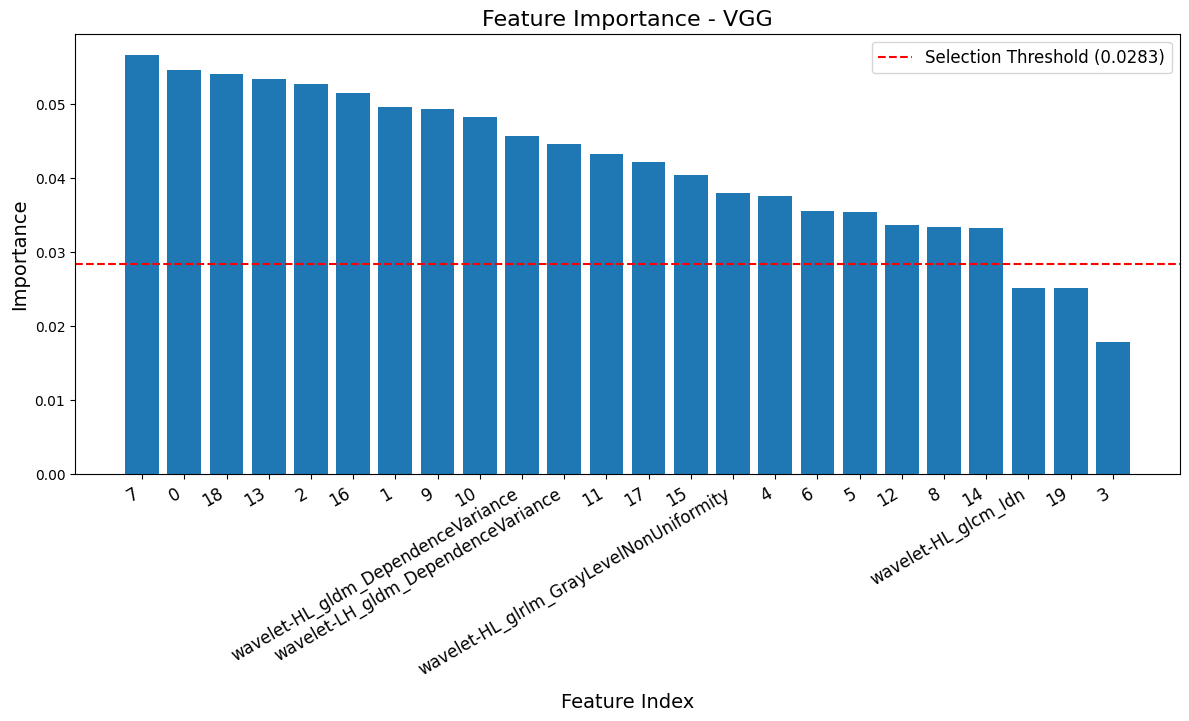

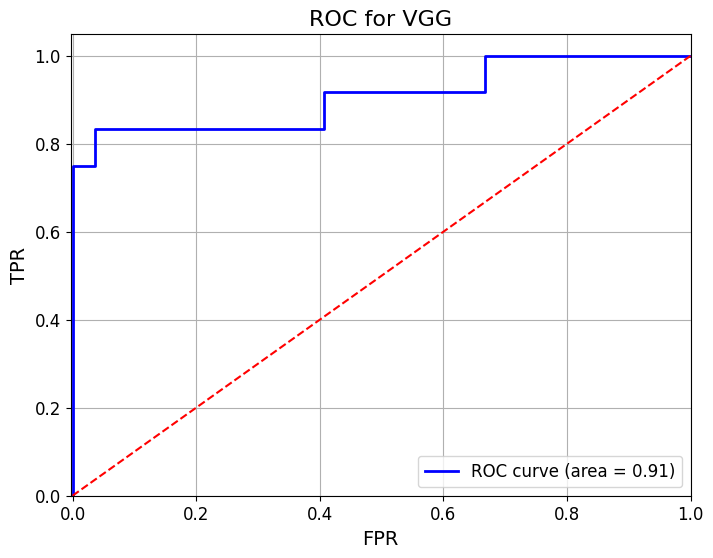


------- Final results on the test: -------
Classifier: ensemble
Numero features: 21
F1 Score: 0.6897
ROC AUC: 0.9074
Accuracy: 0.7692
Balanced Accuracy: 0.7870
Best Threshold: 0.02830393385767494
Confusion Matrix (Test):
[[20  7]
 [ 2 10]]


In [18]:
results_importance, important_features, trained_classi, roc_results = classification_method_features_fixed_importance(
    'RF', best_classifier, X_train1, Y_train1, X_test, y_test, df_combined, network_name, roc_results
)

## to save the trained classifier and the features kept by importance (to be used in the 2.5D)
#pd.DataFrame(important_features, columns=['Important Features']).to_csv(f'../Combinations/important_features_{network_name}_{type_image}.csv', index=False)
#joblib.dump(trained_classi, f'../Combinations/trained_classifier_{network_name}_{type_image}.pkl')


# Print the final test metrics
print(f"\n------- Final results on the test: -------")
print(f"Classifier: {results_importance['classifier']}")
print(f"Numero features: {results_importance['number_features']}")
print(f"F1 Score: {results_importance['f1']:.4f}")
print(f"ROC AUC: {results_importance['roc_auc']:.4f}")
print(f"Accuracy: {results_importance['accuracy']:.4f}")
print(f"Balanced Accuracy: {results_importance['balanced_accuracy']:.4f}")
print(f"Best Threshold: {results_importance['best_threshold']}")
print(f"Confusion Matrix (Test):\n{results_importance['confusion_matrix']}")

#### plot roc multiple

In [958]:
plt.figure(figsize=(10, 8))

networks=['VGG', 'ResNet', 'Inception', 'IncRes']
for network in networks: 
    if(network=='VGG'):
        color='green'
    if(network=='ResNet'):
        color='orange'
    if(network=='IncRes'):
        color='blue'
    if(network=='Inception'):
        color='red'

    plt.plot(roc_results[network]['fpr'], roc_results[network]['tpr'], color=color, label=f'{network} (area = {roc_results[network]["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('ROC Curve for different models', fontsize=16)
plt.legend(loc='lower right', fontsize=12) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show() 

KeyError: 'VGG'

<Figure size 1000x800 with 0 Axes>

## 2.5

In [19]:
type_image='Full'
network_name='VGG'
prediction_mode='Max'

In [20]:
## load the important features, the trained classifier for 2D, the CSV comined and the deep features of all slices
important_features = pd.read_csv(f'../Combinations/important_features_{network_name}_{type_image}.csv')['Important Features'].to_numpy()
trained_classi= joblib.load(f'../Combinations/trained_classifier_{network_name}_{type_image}.pkl')
selected_features_csv=f"../Combinations/selected_features_{network_name}_rad_{type_image}.csv"
zip_file_path= f"../CSVFeatures/2.5D/{type_image}/{network_name}_All_Slices_{type_image}.zip"

zip_file_path_rad = "../CSVFeatures/2.5D/Radiomica_Wavelet_25D.csv.zip"
file_path_area = "../indici_aree/aree_03.npy"


####  Creation of new 2.5D dataset

In [ ]:
# Load deep features encoder for every slice
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    with zip_ref.open(csv_filename) as csv_file:
        data_encoder = pd.read_csv(csv_file)


# Only keep the slices with at least 30% of the area 
arraytuple = np.load(file_path_area)
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]
arraytuple_sorted = sorted(arraytuple, key=lambda t: t[0])

patients_slices = {}
for t in arraytuple_sorted:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:]

final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])
filtered_data = data_encoder[
    data_encoder.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]
filtered_patients = []
for patient_id in sorted(patients_slices):
    filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    slices = []
    for _, slice_row in filtered_patient_data.iterrows():
        # Only select the filtered columns for every slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    filtered_patients.append(slices)


# Load selected features and filter accordingly

selected_features_csvdf = pd.read_csv(selected_features_csv)
print(selected_features_csvdf.head())
second_csv_numeric_columns = [col for col in selected_features_csvdf.columns if col.isdigit()]
selected_columns = ['Patient', 'Slice'] + [f'Feature_{col}' for col in second_csv_numeric_columns]
filtered_and_ordered_data = filtered_data[selected_columns]
filtered_and_ordered_data = filtered_and_ordered_data.reset_index(drop=True)
filtered_and_ordered_data_encoder = filtered_and_ordered_data.sort_values(by='Patient').reset_index(drop=True)
print(filtered_and_ordered_data_encoder.head())


###########################################
# Now the same for Radiomics

with zipfile.ZipFile(zip_file_path_rad, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    with zip_ref.open(csv_filename) as csv_file:
        data_radiomics = pd.read_csv(csv_file)

patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)

final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

filtered_data = data_radiomics[
    data_radiomics.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

filtered_patients = []
for patient_id in loaded_patients:
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Load selected features and filter accordingly
last_four_columns = selected_features_csvdf.iloc[:, -4:]
last_four_column_names = last_four_columns.columns.tolist()
selected_columns_rad = ['Paziente', 'Slice'] + last_four_column_names
filtered_and_ordered_data_rad = filtered_data[selected_columns_rad]

filtered_and_ordered_data_rad = filtered_and_ordered_data_rad.reset_index(drop=True)
filtered_and_ordered_data_rad = filtered_and_ordered_data_rad.sort_values(by='Paziente').reset_index(drop=True)
print(filtered_and_ordered_data_rad.head())


###############################
# Gather the features

final_data_encoder = filtered_and_ordered_data_encoder.copy()

features_rad = filtered_and_ordered_data_rad.columns[2:]

# Iter the rows of 
for i, row in final_data_encoder.iterrows():
    patient_value, slice_value = row.iloc[0], row.iloc[1]
    
    # Look for matching rows in the radiomic dataset
    matching_row = filtered_and_ordered_data_rad[
        (filtered_and_ordered_data_rad.iloc[:, 0] == patient_value) &
        (filtered_and_ordered_data_rad.iloc[:, 1] == slice_value)
    ]
    
    # If one matching row if found, gather the features
    if not matching_row.empty:
        # Add features found as new columns
        for col in features_rad:
            final_data_encoder.loc[i, col] = matching_row.iloc[0][col]

final_vector = []

# Only one patients list
unique_patients = final_data_encoder['Patient'].unique()


for patient in unique_patients:
    # Filter the rows corresponding to the actual patient
    patient_data = final_data_encoder[final_data_encoder['Patient'] == patient]
    
    patient_slices = []

    for _, row in patient_data.iterrows():
        slice_features = row.iloc[2:].tolist()
        patient_slices.append(slice_features)
    
    final_vector.append(patient_slices)



   Paziente        342        493        347           5        430  \
0         5  115.32419  220.19945    0.00000  246.676650  265.36368   
1        12  548.97130  544.20740  229.54079   24.462936  867.39844   
2        15  470.38986  615.88400  214.25523  310.453800  813.63930   
3        16  748.56520  596.93200  231.22762    0.000000  896.75330   
4        17  965.03200  686.81540  223.86882    0.000000  920.95770   

          29        172         425         77  ...        107        487  \
0  597.88040   91.86074   125.98585    0.00000  ...  116.28813  244.91034   
1  157.95700  238.23634  1691.56620  265.51080  ...  315.26587  368.45685   
2  432.59370  313.49136   783.05950  529.13440  ...  181.15025  506.28180   
3  798.49170  254.90842  1375.77600  229.58495  ...  228.44138  594.98740   
4  164.21875  412.59590  1300.44850  327.15582  ...  365.01117  771.37964   

           38           6         418         499  \
0  107.305410   271.12560  317.662140  393.518770   
1   

### Train-test split

In [22]:
train_set, test_set, train_labels, test_labels = train_test_split(final_vector, labels, test_size=0.3, shuffle=False)

### Test metrics

In [23]:
best_case = test_classification_25_Combined(trained_classi, prediction_mode, test_set, test_labels, important_features)

# Print metrics
print("Evaluation Metrics:")
print(f"F1 Score: {best_case['f1']}")
print(f"Accuracy: {best_case['accuracy']}")
print(f"ROC AUC: {best_case['roc_auc']}")
print(f"Balanced Accuracy: {best_case['balanced_accuracy']}")
print("Confusion Matrix:")
print(best_case['confusion_matrix'])

Evaluation Metrics:
F1 Score: 0.8695652173913043
Accuracy: 0.9230769230769231
ROC AUC: 0.8888888888888888
Balanced Accuracy: 0.8981481481481481
Confusion Matrix:
[[26  1]
 [ 2 10]]


### PLOTS

#### plot single ROC AUC

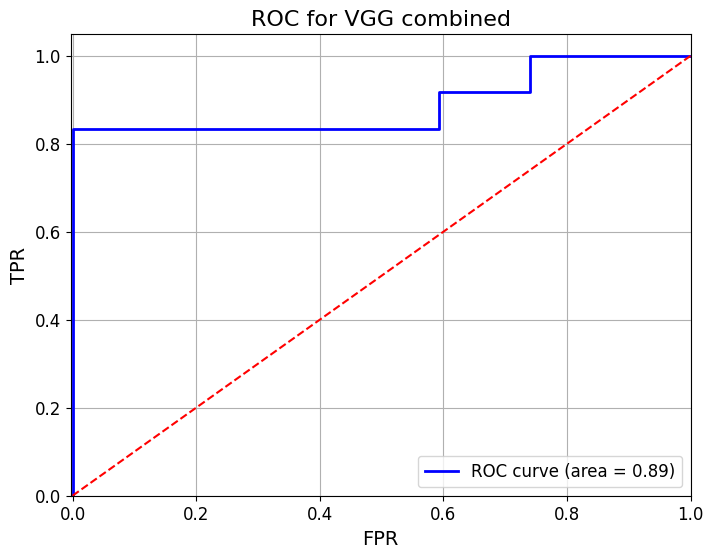

In [1383]:

y_true = y_test
y_scores = best_case['y_proba'] 

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5)  # Linea diagonale
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title(f'ROC for {network_name} combined', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()


#### Multiple ROCs

In [1345]:
roc_results25={}

In [1384]:
roc_results25[network_name]={
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc':roc_auc
}

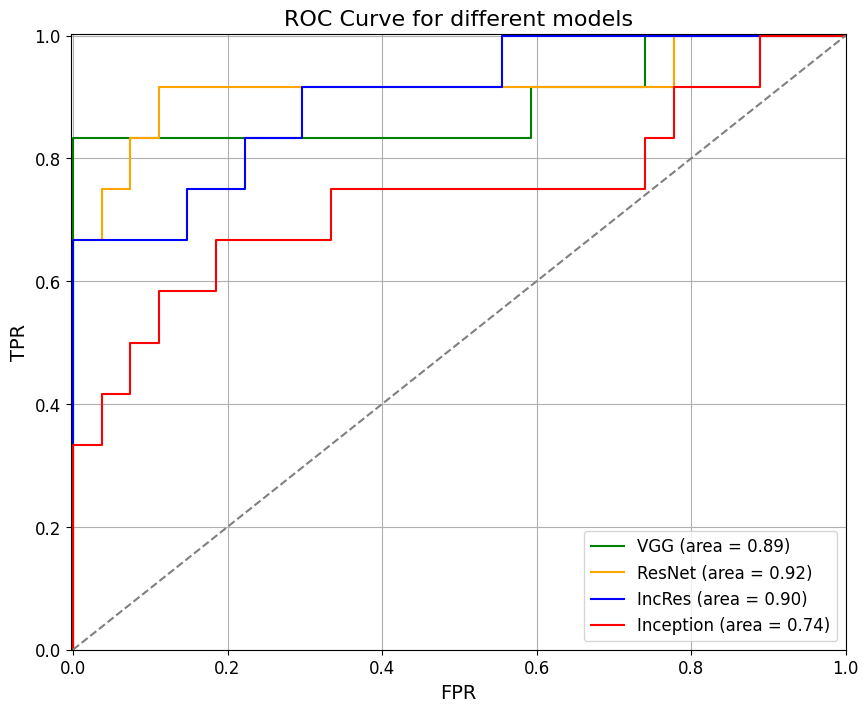

In [1385]:
plt.figure(figsize=(10, 8))

networks=['VGG', 'ResNet', 'Inception', 'IncRes']
for network in networks: 
    if(network=='VGG'):
        color='green'
    if(network=='ResNet'):
        color='orange'
    if(network=='IncRes'):
        color='blue'
    if(network=='Inception'):
        color='red'

    plt.plot(roc_results25[network]['fpr'], roc_results25[network]['tpr'], color=color, label=f'{network} (area = {roc_results25[network]["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('ROC Curve for different models', fontsize=16)
plt.legend(loc='lower right', fontsize=12) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show() 